In [2]:
# !pip install torch
# !pip install torchvision

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [94]:
# Fully Connected VAE Architecture
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 32*32*3))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [95]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 3072), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [96]:
# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [97]:
# Load CIFAR dataset and run the training
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [98]:
fcvae = FCVAE(input_dim=3072, hidden_dim=768, latent_dim=128)
optimizer = optim.Adam(fcvae.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(fcvae, train_loader, optimizer, epoch)


Epoch 1, Loss: 1967.2246453125
Epoch 2, Loss: 1900.2906271875
Epoch 3, Loss: 1879.720694375
Epoch 4, Loss: 1866.6255371875
Epoch 5, Loss: 1860.1479825
Epoch 6, Loss: 1855.688560625
Epoch 7, Loss: 1852.4364653125
Epoch 8, Loss: 1849.4723278125
Epoch 9, Loss: 1846.9447275
Epoch 10, Loss: 1844.904191875


In [99]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=32):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):

        axs[i].imshow(generated_images[i].view(3,32,32).permute(1, 2, 0))
        axs[i].axis('off')
    plt.show()




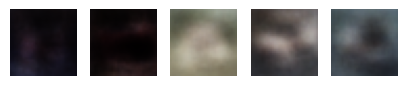

In [ ]:
generate_images(fcvae, num_images=5, latent_dim=128)

In [103]:
# Convolutional VAE Architecture
class CVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, (3,3), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, (3,3), stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)
        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 128*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, (3,3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, (3,3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, (3,3), stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        h1 = x.view(x.size(0), -1)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decoder(z)
        return self.decoder(x.view(x.size(0), 128, 4, 4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [109]:
cvae = CVAE(latent_dim=128)
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 3, 32, 32), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


for epoch in range(1, 6):
    train(cvae, train_loader, optimizer, epoch)


Epoch 1, Loss: 1926.28186625
Epoch 2, Loss: 1847.95889375
Epoch 3, Loss: 1835.707845625
Epoch 4, Loss: 1830.7504971875
Epoch 5, Loss: 1827.5926215625


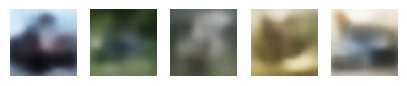

In [111]:
generate_images(cvae, num_images=5, latent_dim=128)

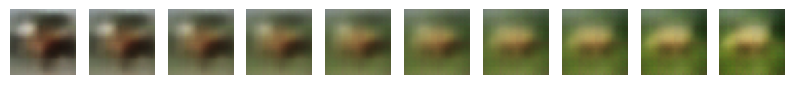

In [122]:
def interpolate_images(model, latent_dim, steps=10):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample 2 random points from the latent space (standard normal distribution)
        z = torch.randn(2, latent_dim)
        # Interpolate between these points
        interpolation = torch.zeros(steps, latent_dim)
        for i, alpha in enumerate(torch.linspace(0, 1, steps)):
            interpolation[i] = alpha * z[0] + (1 - alpha) * z[1]

        # Decode these points to generate images
        generated_images = model.decode(interpolation).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, steps, figsize=(steps, 1.5))
    for i in range(steps):

        axs[i].imshow(generated_images[i].view(3,32,32).permute(1, 2, 0))
        axs[i].axis('off')
    plt.show()

interpolate_images(cvae, latent_dim=128, steps=10)

In [123]:
# Load Food 101 dataset
train_dataset = datasets.Food101('./data', split='train', download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

TypeError: Food101.__init__() got an unexpected keyword argument 'train'